# Prediction of tango_ori

In [7]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import time as time_

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split

from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
import seaborn as sns

In [8]:
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper")

def plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size, network, filename=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'network: {network}, loss: {loss.item():.4f}, dist_metric: {dist_metric}, agg_type: {agg_type}, normalize: {normal}', fontsize=16, color='white')

    legend_elements = [Patch(facecolor='orange', edgecolor='black', label='Predictions on train data'),
                       Patch(facecolor='red', edgecolor='black', label='Predictions on test data'),
                       Patch(facecolor='green', edgecolor='black', label='Orientation from Tango')]

    for i, title in enumerate(['x', 'y', 'z', 'w']):
        ax[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        if np.linalg.norm(predictions-tango_ori) > np.linalg.norm(predictions+tango_ori):
            predictions = -predictions
        ax[i//2, i%2].plot(time[:train_size], predictions[:train_size, i], color='orange')
        ax[i//2, i%2].plot(time[train_size:], predictions[train_size:, i], color='red')
        ax[i//2, i%2].plot(time, tango_ori[:, i], color='green')
        ax[i//2, i%2].set_title(f'Orientation {title}', color='white')
        ax[i//2, i%2].set_ylabel('Orientation', color='white')
        ax[i//2, i%2].set_xlabel('Time', color='white')
        ax[i//2, i%2].grid(True, which='both', color='gray')
        ax[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        ax[i//2, i%2].grid(which='major', alpha=0.5)
        ax[i//2, i%2].tick_params(color='white')
        ax[i//2, i%2].xaxis.label.set_color('white')
        ax[i//2, i%2].yaxis.label.set_color('white')
        ax[i//2, i%2].tick_params(axis='x', colors='white')
        ax[i//2, i%2].tick_params(axis='y', colors='white')
        legend = ax[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_edgecolor('black')
        legend.get_texts()[0].set_color('black')
        legend.get_title().set_color('black')
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi=420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

def plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, t, num_elems = 2000, filename=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Quaternion Comparison', fontsize=16, color='white')

    legend_elements = [Line2D([0], [0], color='red', lw=2, linestyle='dashed', label='Madgwick'),
                       Line2D([0], [0], color='green', lw=2, linestyle='dashed', label='Mahony'),
                       Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='EKF'),
                       Line2D([0], [0], color='black', lw=2, label='ekf_ori'),
                       Line2D([0], [0], color='black', lw=2, linestyle='dotted', label='tango_ori'),
                       Line2D([0], [0], color='grey', lw=2, label='q_pred')]

    for i, title in enumerate(['w', 'x', 'y', 'z']):
        axs[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        axs[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        axs[i//2, i%2].plot(t[-num_elems:], Q_1[-num_elems:, i], color='red', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], Q_2[-num_elems:, i], color='green', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], Q_ekf[-num_elems:, i], color='blue', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], q_pred[-num_elems:, i], color='grey')
        axs[i//2, i%2].plot(t[-num_elems:], ekf_ori[-num_elems:, i], color='black')
        axs[i//2, i%2].plot(t[-num_elems:], tango_ori[-num_elems:, i], color='black', linestyle='dotted')
        axs[i//2, i%2].set_title(f'Quaternion {title}', color='white')
        axs[i//2, i%2].set_ylabel('Value', color='white')
        axs[i//2, i%2].set_xlabel('Time (s)', color='white')
        axs[i//2, i%2].grid(True, which='both', color='gray')
        axs[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        axs[i//2, i%2].grid(which='major', alpha=0.5)
        axs[i//2, i%2].tick_params(color='white')
        axs[i//2, i%2].xaxis.label.set_color('white')
        axs[i//2, i%2].yaxis.label.set_color('white')
        axs[i//2, i%2].tick_params(axis='x', colors='white')
        axs[i//2, i%2].tick_params(axis='y', colors='white')
        legend = axs[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_edgecolor('black')
        legend.get_texts()[0].set_color('black')
        legend.get_title().set_color('black')
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi = 420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()


def plot_losses(train_losses, valid_losses, min_epoch, filename=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(train_losses, label='Train loss', color='orange')
    ax.plot(valid_losses, label='Validation loss', color = 'red')
    ax.vlines(min_epoch, 0, max(train_losses), color='black', linestyle='dashed', label='Early stopping')

    ax.set_xlabel('Epochs', color='white')
    ax.set_ylabel('Loss', color='white')
    ax.set_title('Training and Validation Loss', color='white')
    ax.grid(True, which='both', color='gray')
    ax.tick_params(colors='white')
    ax.legend()

    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi=420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

In [9]:
N_train = 20000
N_test = 5000

file_path = '/home/asp/Downloads/AML/final-project/data/data_for_project'

if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data, load_much_data, Theta
column_names_X = ['synced/gyro', 'synced/acce', 'synced/magnet', 'synced/rv', 'synced/game_rv', 'synced/time']
column_names_y = ['pose/ekf_ori', 'pose/tango_ori', 'pose/tango_pos']
data_dict = load_much_data(N_train, N_test, file_path, column_names_X, column_names_y, verbose=True)

print(data_dict.keys())
print(data_dict['X-train'].keys())

gyro = data_dict['X-train']['synced/gyro']
acc = data_dict['X-train']['synced/acce']
mag = data_dict['X-train']['synced/magnet']
rv = data_dict['X-train']['synced/rv']
game_rv = data_dict['X-train']['synced/game_rv']
time = data_dict['X-train']['synced/time']
dt = np.mean(np.diff(time))
ekf_ori = data_dict['y-train']['pose/ekf_ori']
tango_ori = data_dict['y-train']['pose/tango_ori']
num_samples = ekf_ori.shape[0]

print(gyro.shape)
print(tango_ori.shape)
print(data_dict['X-test']['synced/gyro'].shape)
print(dt)

q_0 = ekf_ori[0,:]

using ['a000_1'] for testing and the remaining (1) for training
using 1 directories for training
test dirs: ['a000_1'] train dirs: ['a000_2']
Loading a total of 20000, with 20000 points from each of 1 directories
a000_1
Loading file: /home/asp/Downloads/AML/final-project/data/data_for_project/a000_1/data.hdf5
a000_2
Loading file: /home/asp/Downloads/AML/final-project/data/data_for_project/a000_2/data.hdf5
dir: a000_2 is in train_dirs
dict_keys(['X-train', 'y-train', 'X-test', 'y-test'])
dict_keys(['synced/gyro', 'synced/acce', 'synced/magnet', 'synced/rv', 'synced/game_rv', 'synced/time'])
(20000, 3)
(20000, 4)
(5000, 3)
0.005000000000109139


In [10]:
# Madgwick filter
start = time_.time()
q_0 = np.array([1, 0, 0, 0])
gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q
end = time_.time()
print("Madgwick filter time: ", end - start)

# Mahony filter
start = time_.time()
k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q
end = time_.time()
print("Mahony filter time: ", end - start)

# EKF
start = time_.time()
acc_var = 10
gyro_var = 5
mag_var = 20
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q
end = time_.time()
print("EKF time: ", end - start)

# Custom filter
start = time_.time()
q_pred = np.zeros((len(gyro), 4))
q_pred[0] = tango_ori[0]
factor= .0025
for i in range(1,N_train):
    q_pred[i] = Theta(gyro[i]*factor, dt=dt)@q_pred[i-1]
end = time_.time()
print("Custom filter time: ", end - start)

########################################################################

q_0 = np.mean(Q_1[:1000], axis = 0)

gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q

q_0 = np.mean(Q_2[:1000], axis = 0)

k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q

q_0 = np.mean(Q_ekf[:1000], axis = 0)

acc_var = 10
gyro_var = 5
mag_var = 20
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q

q_pred = np.zeros((len(gyro), 4))
q_pred[0] = tango_ori[0]
factor= .0025
for i in range(1,N_train):
    q_pred[i] = Theta(gyro[i]*factor, dt=dt)@q_pred[i-1]


if not torch.is_tensor(gyro):
    gyro = torch.from_numpy(gyro).float()
if not torch.is_tensor(acc):
    acc = torch.from_numpy(acc).float()
if not torch.is_tensor(mag):
    mag = torch.from_numpy(mag).float()
if not torch.is_tensor(rv):
    rv = torch.from_numpy(rv).float()
if not torch.is_tensor(game_rv):
    game_rv = torch.from_numpy(game_rv).float()
if not torch.is_tensor(Q_1):
    Q_1 = torch.from_numpy(Q_1).float()
if not torch.is_tensor(Q_2):
    Q_2 = torch.from_numpy(Q_2).float()
if not torch.is_tensor(Q_ekf):
    Q_ekf = torch.from_numpy(Q_ekf).float()
if not torch.is_tensor(q_pred):
    q_pred = torch.from_numpy(q_pred).float()
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

Madgwick filter time:  1.263828992843628
Mahony filter time:  2.1203417778015137
EKF time:  5.916253328323364
Custom filter time:  0.9569740295410156


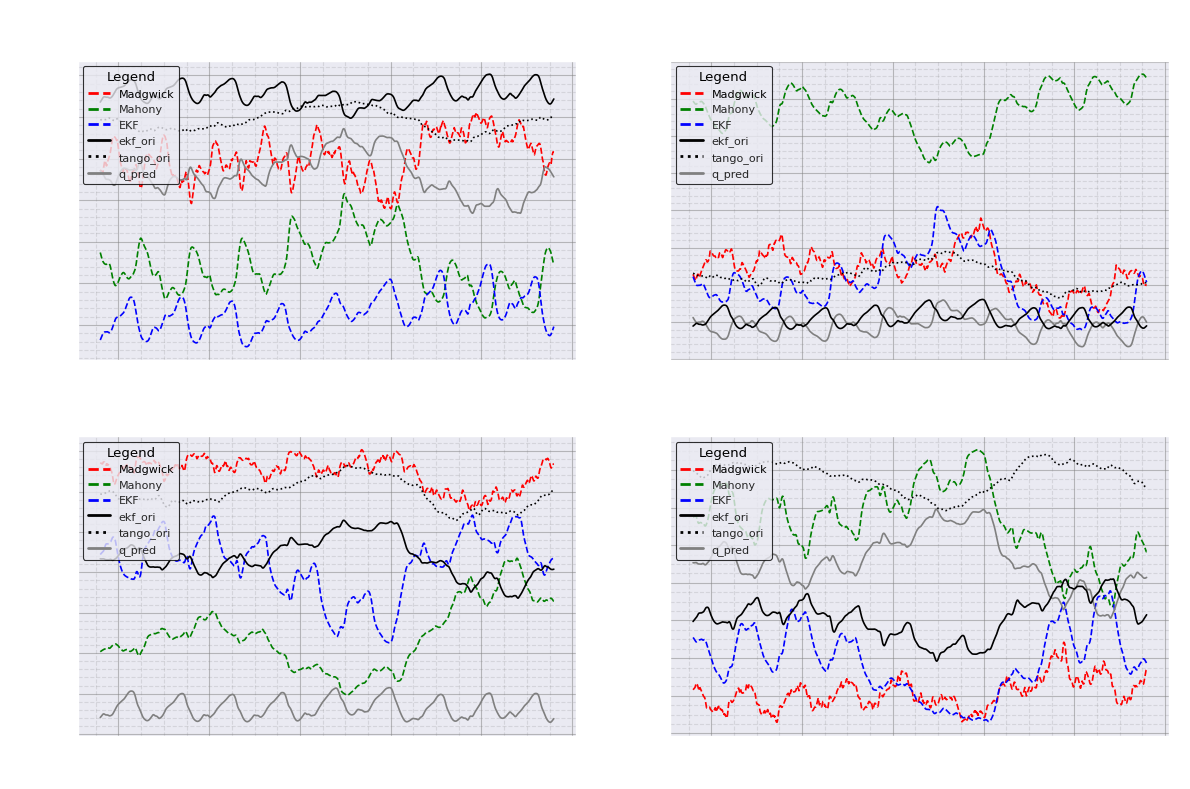

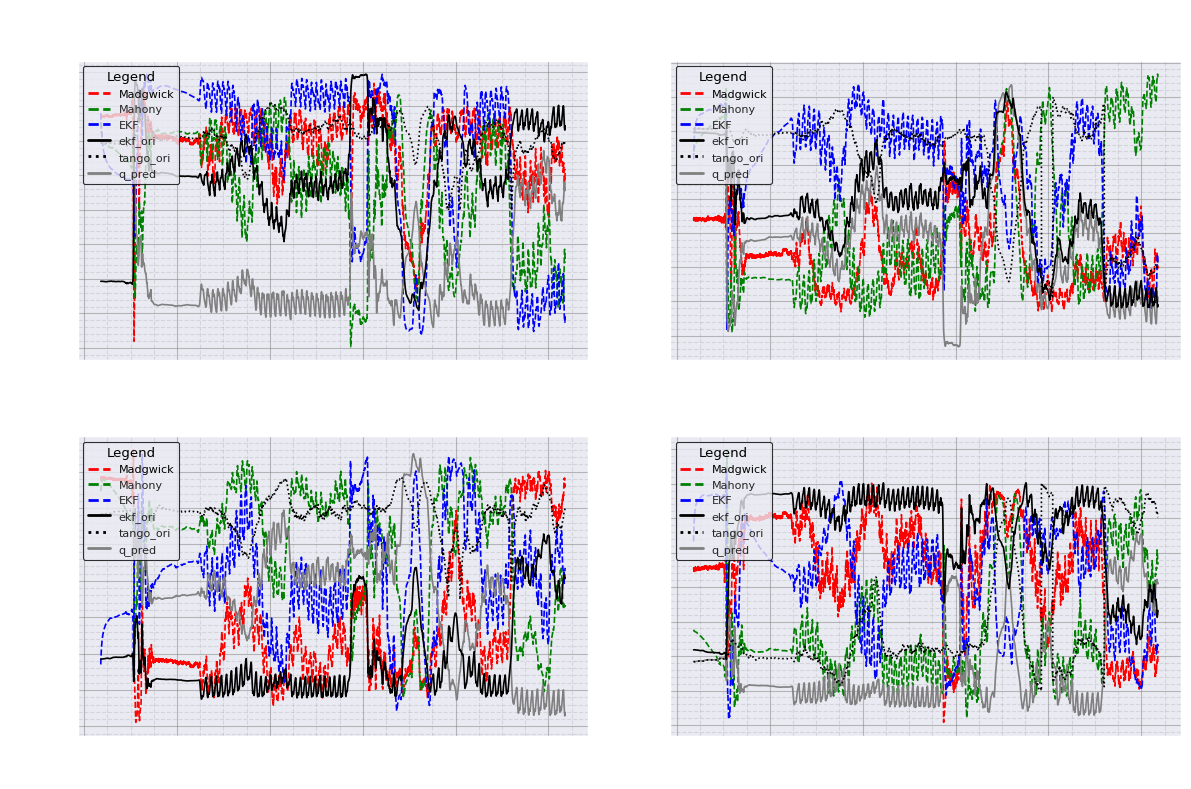

In [11]:
plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, time)
plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, time, num_elems=20000)

## Custom Loss Function

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, dist_metric='phi2', agg_type='L2', normal=False):
        super().__init__()
        self.dist_metric = dist_metric
        self.agg_type = agg_type
        self.normal = normal

    def forward(self, q1, q2):
        if self.normal:
            q1 = self.normalize(q1)
            q2 = self.normalize(q2)
        if self.dist_metric == 'phi2':
            return self.phi2(q1, q2)
        elif self.dist_metric == 'phi4':
            return self.phi4(q1, q2)
        elif self.dist_metric == 'phi5':
            return self.phi5(q1, q2)
        else:
            raise ValueError('Invalid distance metric')

    def phi2(self, q1, q2):
        return self.aggregate(torch.min(torch.norm(q1 - q2), torch.norm(q1 + q2)))

    def phi4(self, q1, q2):
        return self.aggregate(1 - torch.abs(torch.einsum('ij,ij->i', q1, q2)))

    def phi5(self, q1, q2):
        R1 = self.quat_to_rot(q1)
        R2 = self.quat_to_rot(q2)
        return self.aggregate(torch.norm(torch.eye(3, device=q1.device)[None, :, :] - torch.bmm(R1, R2.transpose(-2, -1)), p='fro'))

    def quat_to_rot(self, q):
        q = self.normalize(q)

        q_r, q_i, q_j, q_k = q.split(1, dim=-1)
        q_r, q_i, q_j, q_k = q_r.squeeze(-1), q_i.squeeze(-1), q_j.squeeze(-1), q_k.squeeze(-1)

        R = torch.zeros((*q.shape[:-1], 3, 3), device=q.device)
        R[..., 0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
        R[..., 0, 1] = 2 * (q_i * q_j - q_k * q_r)
        R[..., 0, 2] = 2 * (q_i * q_k + q_j * q_r)
        R[..., 1, 0] = 2 * (q_i * q_j + q_k * q_r)
        R[..., 1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
        R[..., 1, 2] = 2 * (q_j * q_k - q_i * q_r)
        R[..., 2, 0] = 2 * (q_i * q_k - q_j * q_r)
        R[..., 2, 1] = 2 * (q_j * q_k + q_i * q_r)
        R[..., 2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

        return R
    
    def normalize(self, q):
        return q / torch.norm(q, dim=-1, keepdim=True)

    def aggregate(self, x):
        if self.agg_type == 'L1':
            return torch.mean(torch.abs(x))
        elif self.agg_type == 'L2':
            return torch.mean(x ** 2)
        elif self.agg_type == 'log':
            return -torch.mean(torch.log(x))
        else:
            raise ValueError('Invalid aggregation type')

In [13]:
# Instantiate the custom loss function
loss_func = CustomLoss(dist_metric='phi2', agg_type='L2', normal=False)

# Compute the loss between tango_ori and the filters for the last 4000 elements
loss_q_pred = loss_func(tango_ori[-4000:], q_pred[-4000:])
loss_Q_ekf = loss_func(tango_ori[-4000:], Q_ekf[-4000:])
loss_Q_2 = loss_func(tango_ori[-4000:], Q_2[-4000:])
loss_Q_1 = loss_func(tango_ori[-4000:], Q_1[-4000:])

# Print the computed losses
print(f"Loss between tango_ori and q_pred for the last 4000 elements: {loss_q_pred}")
print(f"Loss between tango_ori and Q_ekf for the last 4000 elements: {loss_Q_ekf}")
print(f"Loss between tango_ori and Q_2 for the last 4000 elements: {loss_Q_2}")
print(f"Loss between tango_ori and Q_1 for the last 4000 elements: {loss_Q_1}")

Loss between tango_ori and q_pred for the last 4000 elements: 9173.8115234375
Loss between tango_ori and Q_ekf for the last 4000 elements: 7772.02197265625
Loss between tango_ori and Q_2 for the last 4000 elements: 7160.62353515625
Loss between tango_ori and Q_1 for the last 4000 elements: 7904.1396484375


## LSTM

Params = [amsgrad: False, beta1: 0.506551715352944, beta2: 0.9695833421124962, hidden_size: 44, learning_rate: 0.009988984621847889, num_layers: 1, optimizer: Adam, weight_decay: 0.0197288366670273]

In [14]:
input_size = 25
hidden_size = 44
num_layers = 1
output_size = 4
num_epochs = 300
learning_rate = 0.005
weight_decay = 0.02
betas = (0.51, 0.97)
amsgrad = False
dist_metric = 'phi2'
agg_type = 'L2'
normal = False

parameters = {
    'optimizer': 'Adam',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'betas': betas,
    'amsgrad': amsgrad,
}

class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        
        return out

Number of parameters: 25348


Epoch 1/300, Train Loss: 12379.5586, Validation Loss: 2671.3042
Epoch 2/300, Train Loss: 7368.0005, Validation Loss: 2124.4092
Epoch 3/300, Train Loss: 4379.5278, Validation Loss: 1773.8855
Epoch 4/300, Train Loss: 3058.0276, Validation Loss: 1534.3207
Epoch 5/300, Train Loss: 2843.7090, Validation Loss: 1305.3552
Epoch 6/300, Train Loss: 2870.6482, Validation Loss: 1052.0367
Epoch 7/300, Train Loss: 2642.4053, Validation Loss: 816.6223
Epoch 8/300, Train Loss: 2206.7419, Validation Loss: 648.2768
Epoch 9/300, Train Loss: 1785.0020, Validation Loss: 559.9257
Epoch 10/300, Train Loss: 1531.0587, Validation Loss: 529.2009
Epoch 11/300, Train Loss: 1429.7886, Validation Loss: 526.0016
Epoch 12/300, Train Loss: 1394.1084, Validation Loss: 529.6558
Epoch 13/300, Train Loss: 1368.0297, Validation Loss: 531.7119
Epoch 14/300, Train Loss: 1326.1957, Validation Loss: 532.3763
Epoch 15/300, Train Loss: 1264.0975, Validation Loss: 535.2284
Epoch 16/300, Train Loss: 1188.7922, Validation Loss: 540

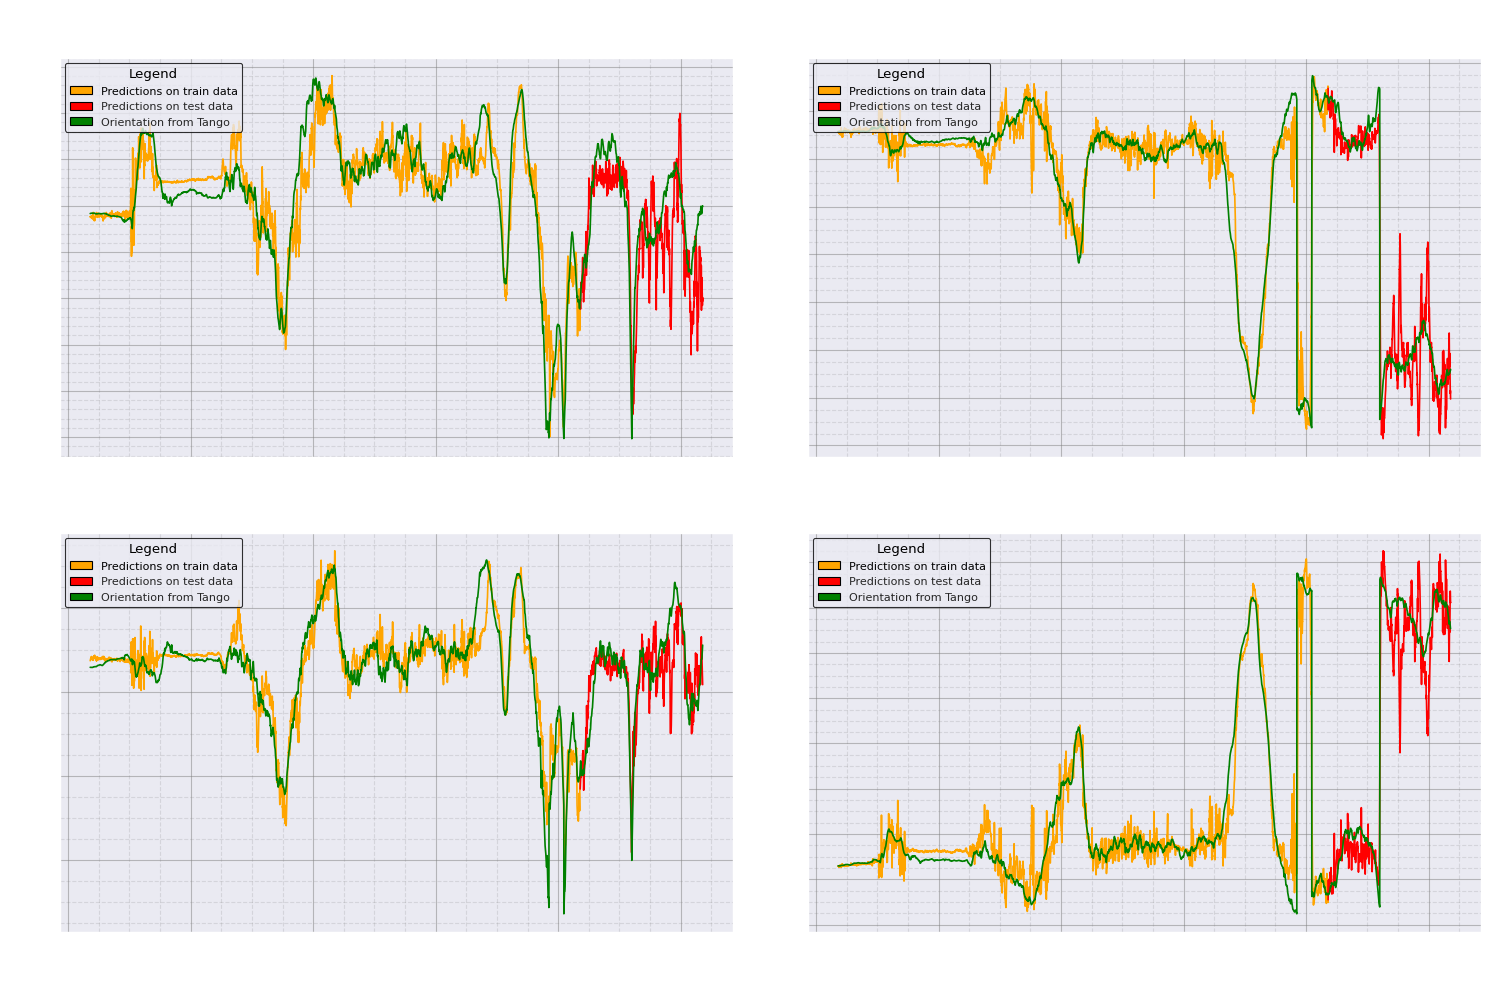

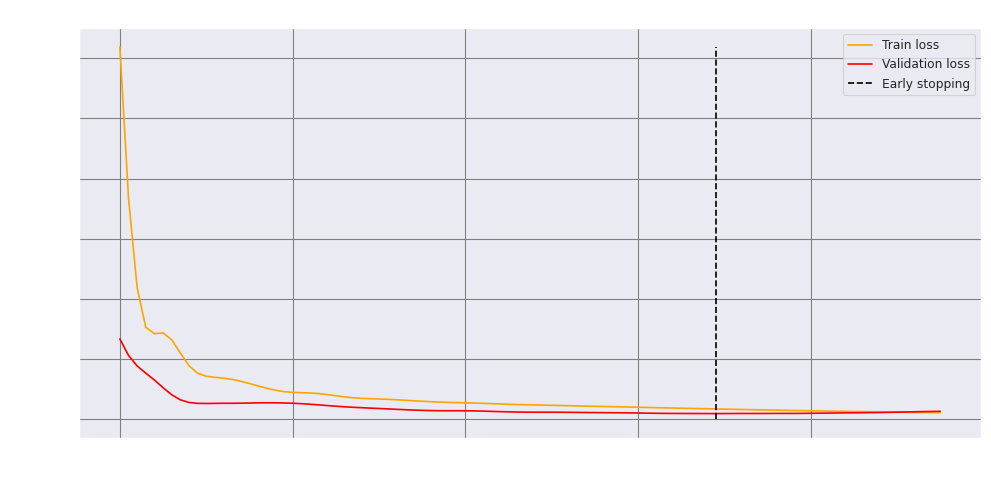

In [15]:
def create_lstm_model():
    start_time = time_.time()
    train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)

    input_size = train_data.shape[1]

    train_data = train_data.view(num_samples, -1, input_size)
    train_labels = tango_ori

    train_size = int(0.8*len(train_data))
    valid_size = len(train_data) - train_size

    valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
    train_data, train_labels = train_data[:train_size], train_labels[:train_size]

    train_data = train_data.view(train_size, -1, input_size)
    valid_data = valid_data.view(valid_size, -1, input_size)

    model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
    model.to('cpu')
    criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)

    patience = 25
    min_valid_loss = np.inf
    patience_counter = 0
    min_epoch = 0

    train_losses = []
    valid_losses = []

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_data)
            valid_loss = criterion(valid_outputs, valid_labels)

        train_losses.append(loss.item())
        valid_losses.append(valid_loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

        if valid_loss < min_valid_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_valid_loss = valid_loss
            min_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print('Early stopping')
            break

    print("Finished Training")
    
    elapsed_time = time_.time() - start_time
    print(f"Time taken to train the model: {elapsed_time} seconds")

    full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)
    full_data = full_data.view(num_samples, -1, input_size)

    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    with torch.no_grad():
        predictions = model(full_data.to('cpu'))

    return model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions

# Keep track of the best model
best_model = None
best_loss = np.inf
best_epoch = -1
best_train_losses = None
best_valid_losses = None
best_train_size = -1
best_predictions = None
best_elapsed_time = -1
lstm_loss = []
training_times = []

for i in range(1):
    model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions = create_lstm_model()
    loss_numpy = min_valid_loss.detach().numpy()
    
    lstm_loss.append(loss_numpy)
    training_times.append(elapsed_time)

    if loss_numpy < best_loss:
        best_model = model
        best_loss = loss_numpy
        best_epoch = min_epoch
        best_train_losses = train_losses
        best_valid_losses = valid_losses
        best_train_size = train_size
        best_predictions = predictions
        best_elapsed_time = elapsed_time

print(f"Average loss: {np.mean(lstm_loss)} +/- {np.std(lstm_loss)}")
print(f"Average training time: {np.mean(training_times)} +/- {np.std(training_times)}")

# Plot the best model
network = 'LSTM'
plot_quaternions(best_loss, dist_metric, agg_type, normal, best_predictions, tango_ori, time, best_train_size, network, filename='lstm_best_model')
plot_losses(best_train_losses, best_valid_losses, best_epoch, filename='lstm_losses')

## GRU network

Params = [beta1: 0.3972976410020912, beta2: 0.4561509603857766, hidden_size: 233, learning_rate: 0.0004953212883244195, num_layers: 2, optimizer: Adamax, weight_decay: 1.8790674142287829e-06]

In [16]:
input_size = 25
hidden_size = 233
num_layers = 2
output_size = 4
num_epochs = 300
learning_rate = 0.0005
weight_decay = 0
betas = (0.40, 0.46)
dist_metric = 'phi2'
agg_type = 'L2'
normal = False

parameters = {
    'optimizer': 'Adamax',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'betas': betas,
}

In [17]:
class GRUOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        
        return out

Number of parameters: 1345346


Epoch 1/300, Train Loss: 15339.3438, Validation Loss: 2255.7478
Epoch 2/300, Train Loss: 6940.0801, Validation Loss: 2247.9187
Epoch 3/300, Train Loss: 4601.4424, Validation Loss: 1795.3348
Epoch 4/300, Train Loss: 4008.5190, Validation Loss: 850.1874
Epoch 5/300, Train Loss: 2200.5947, Validation Loss: 596.1952
Epoch 6/300, Train Loss: 2517.3237, Validation Loss: 489.3549
Epoch 7/300, Train Loss: 1706.4021, Validation Loss: 703.6868
Epoch 8/300, Train Loss: 2216.6743, Validation Loss: 515.1777
Epoch 9/300, Train Loss: 1400.4878, Validation Loss: 509.6919
Epoch 10/300, Train Loss: 1900.8179, Validation Loss: 433.7618
Epoch 11/300, Train Loss: 1252.4701, Validation Loss: 625.4373
Epoch 12/300, Train Loss: 1761.0410, Validation Loss: 414.1712
Epoch 13/300, Train Loss: 1119.0615, Validation Loss: 480.1590
Epoch 14/300, Train Loss: 1574.1970, Validation Loss: 444.6743
Epoch 15/300, Train Loss: 1054.3480, Validation Loss: 569.8999
Epoch 16/300, Train Loss: 1420.4210, Validation Loss: 423.77

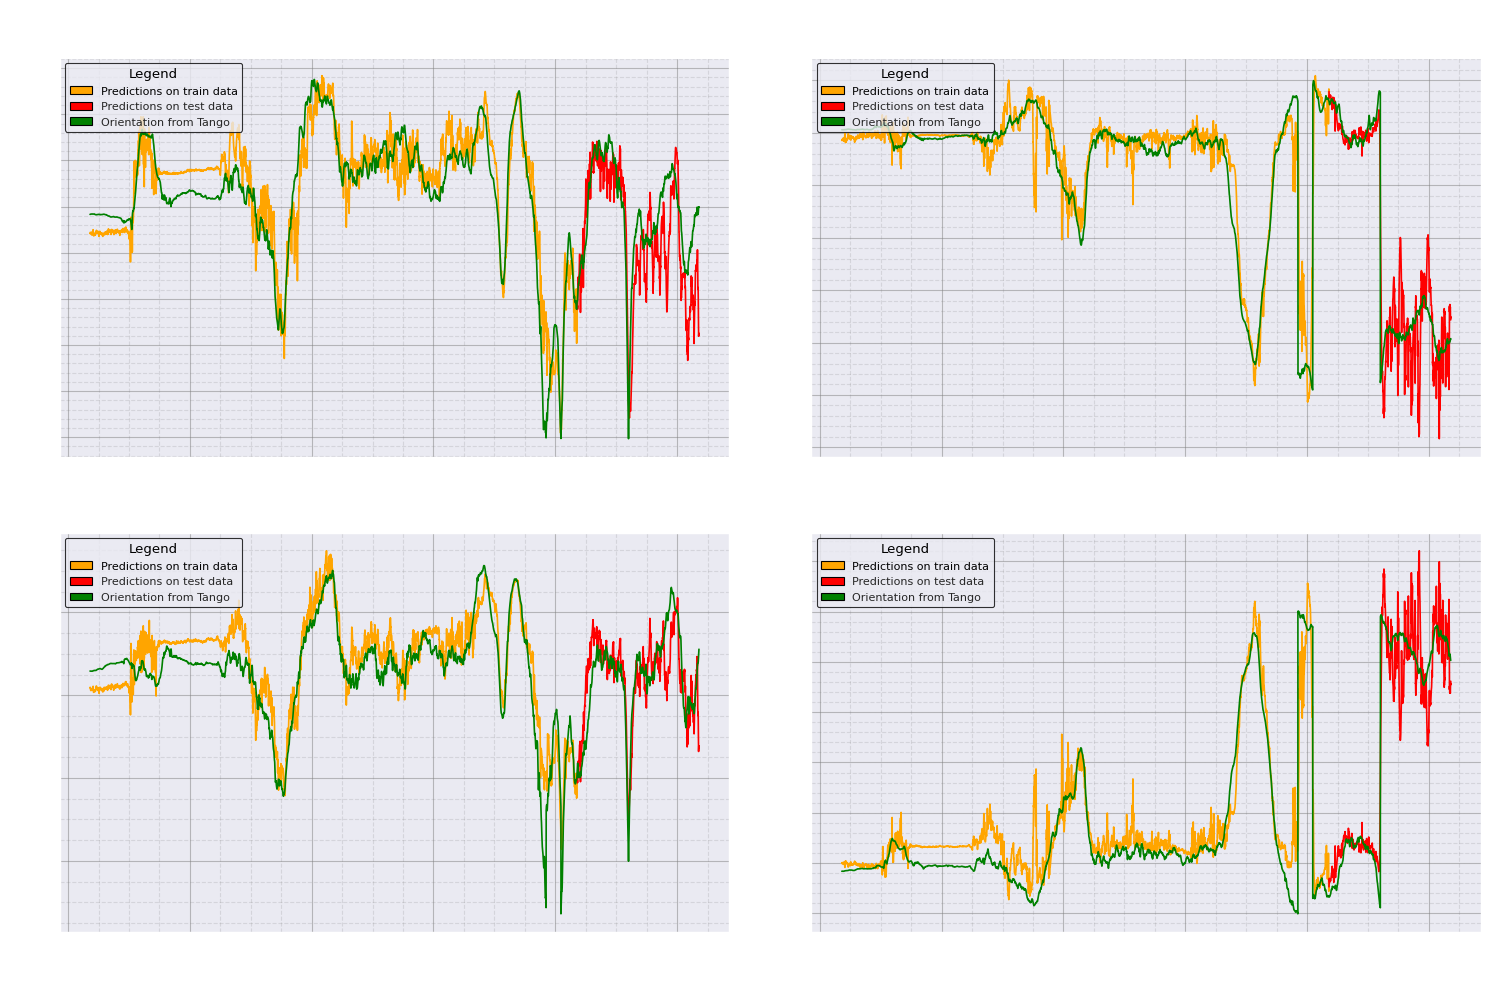

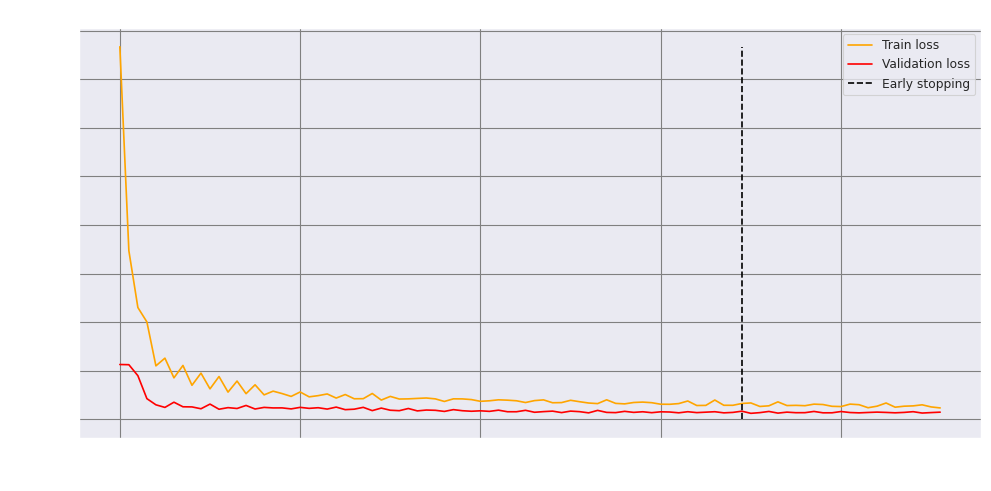

In [18]:
def create_gru_model():
    start_time = time_.time()
    
    train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)

    input_size = train_data.shape[1]

    train_data = train_data.view(num_samples, -1, input_size)
    train_labels = tango_ori

    train_size = int(0.8*len(train_data))
    valid_size = len(train_data) - train_size

    valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
    train_data, train_labels = train_data[:train_size], train_labels[:train_size]

    train_data = train_data.view(train_size, -1, input_size)
    valid_data = valid_data.view(valid_size, -1, input_size)

    model = GRUOrientation(input_size, hidden_size, num_layers, output_size)
    model.to('cpu')
    criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

    optimizer = optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)

    patience = 20
    min_valid_loss = np.inf
    patience_counter = 0

    train_losses = []
    valid_losses = []

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_data)
            valid_loss = criterion(valid_outputs, valid_labels)

        train_losses.append(loss.item())
        valid_losses.append(valid_loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

        if valid_loss < min_valid_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print('Early stopping')
            break

    print("Finished Training")

    elapsed_time = time_.time() - start_time
    print(f"Time taken to train the model: {elapsed_time} seconds")

    full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)
    full_data = full_data.view(num_samples, -1, input_size)

    # Load the best model to make predictions
    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    with torch.no_grad():
        predictions = model(full_data.to('cpu'))

    return model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions

# Keep track of the best model
best_model = None
best_loss = np.inf
best_epoch = -1
best_train_losses = None
best_valid_losses = None
best_train_size = -1
best_predictions = None
best_elapsed_time = -1
gru_loss = []
training_times = []

for i in range(1):
    model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions = create_gru_model()
    min_valid_loss = min_valid_loss.detach().numpy()

    gru_loss.append(min_valid_loss)
    training_times.append(elapsed_time)

    if min_valid_loss < best_loss:
        best_model = model
        best_loss = min_valid_loss
        best_epoch = min_epoch
        best_train_losses = train_losses
        best_valid_losses = valid_losses
        best_train_size = train_size
        best_predictions = predictions
        best_elapsed_time = elapsed_time

print(f"Average loss: {np.mean(gru_loss)} +/- {np.std(gru_loss)}")
print(f"Average training time: {np.mean(training_times)} +/- {np.std(training_times)}")

# Plot the best model
network = 'GRU'
plot_quaternions(best_loss, dist_metric, agg_type, normal, best_predictions, tango_ori, time, best_train_size, network, filename='gru_best_model')
plot_losses(best_train_losses, best_valid_losses, best_epoch, filename='gru_losses')

## RNN network

Params = [amsgrad: False, beta1: 0.7411270688503653, beta2: 0.8811872935240332, hidden_size: 179, learning_rate: 0.0012525954077600788, num_layers: 1, optimizer: AdamW, weight_decay: 0.03356742897772002]

In [19]:
input_size = 25
hidden_size = 179
num_layers = 1
output_size = 4
num_epochs = 300
learning_rate = 0.001
weight_decay = 0.034
betas = (0.74, 0.88)
dist_metric = 'phi2'
agg_type = 'L2'
normal = False
amsgrad = False

parameters = {
    'optimizer': 'AdamW',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'betas': betas,
}

In [20]:
class RNNOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        
        return out

Number of parameters: 75184
Epoch 1/300, Train Loss: 15330.9277, Validation Loss: 2839.6206
Epoch 2/300, Train Loss: 8883.5850, Validation Loss: 1867.1848
Epoch 3/300, Train Loss: 7094.6162, Validation Loss: 1262.4939
Epoch 4/300, Train Loss: 5703.6919, Validation Loss: 1051.0333
Epoch 5/300, Train Loss: 4488.3896, Validation Loss: 1137.0668
Epoch 6/300, Train Loss: 3754.6216, Validation Loss: 1188.2267
Epoch 7/300, Train Loss: 3451.5464, Validation Loss: 997.9238
Epoch 8/300, Train Loss: 3147.5916, Validation Loss: 714.1439
Epoch 9/300, Train Loss: 2781.5618, Validation Loss: 544.9691
Epoch 10/300, Train Loss: 2589.5940, Validation Loss: 488.4501
Epoch 11/300, Train Loss: 2423.2454, Validation Loss: 478.5380
Epoch 12/300, Train Loss: 2166.2109, Validation Loss: 510.7355
Epoch 13/300, Train Loss: 1974.1029, Validation Loss: 544.2700
Epoch 14/300, Train Loss: 1841.3179, Validation Loss: 548.9841
Epoch 15/300, Train Loss: 1724.9911, Validation Loss: 532.6099
Epoch 16/300, Train Loss: 163

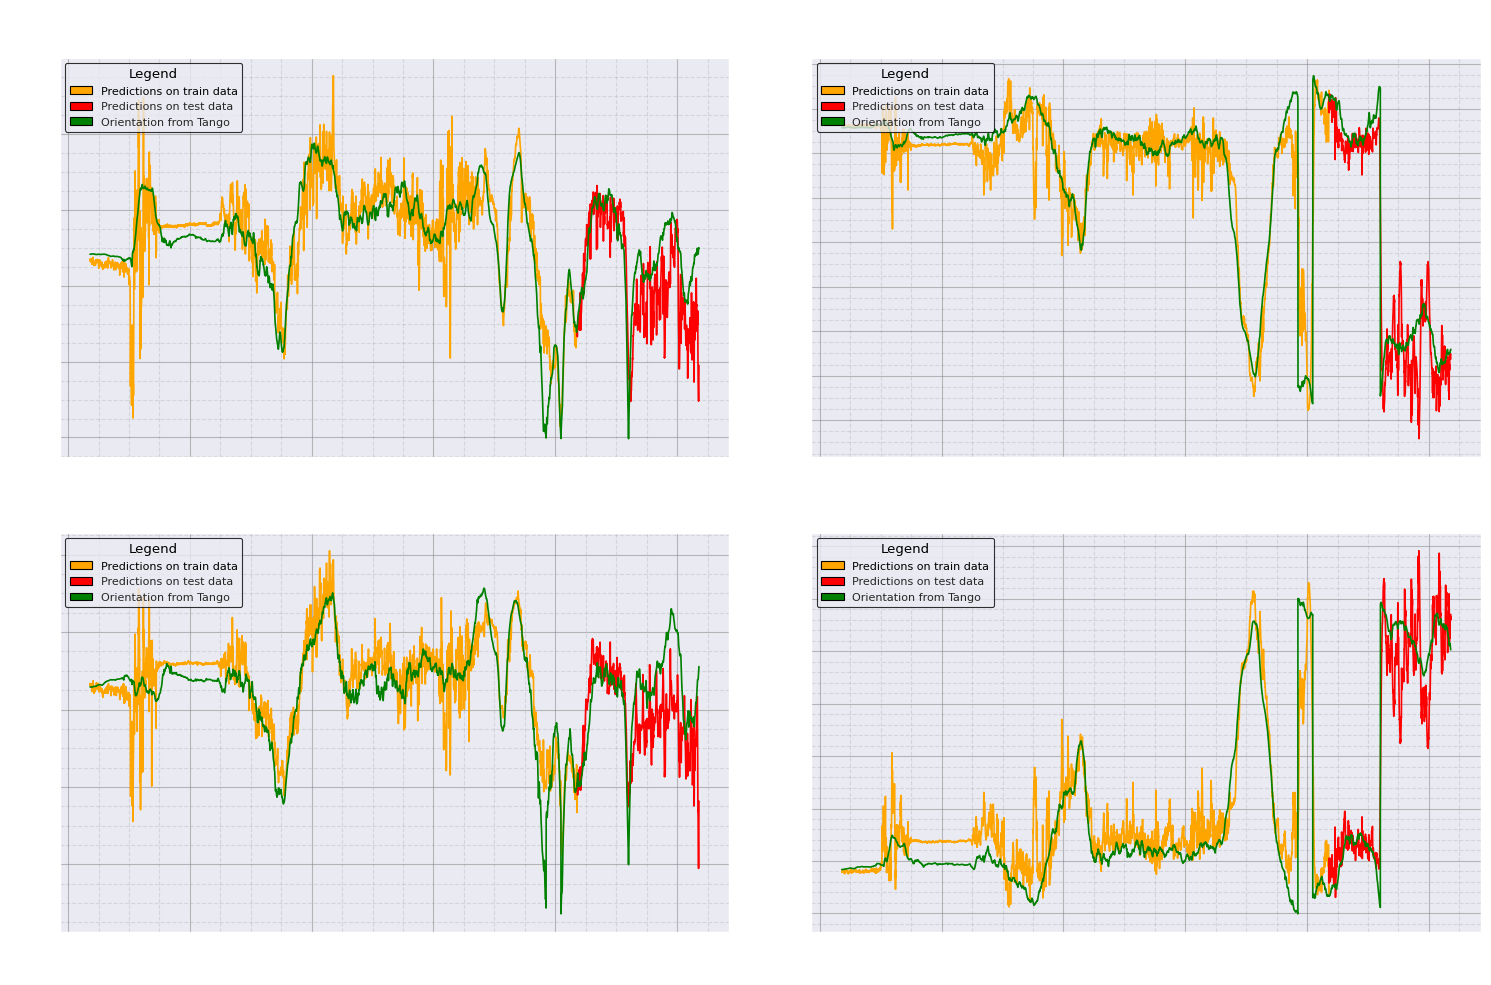

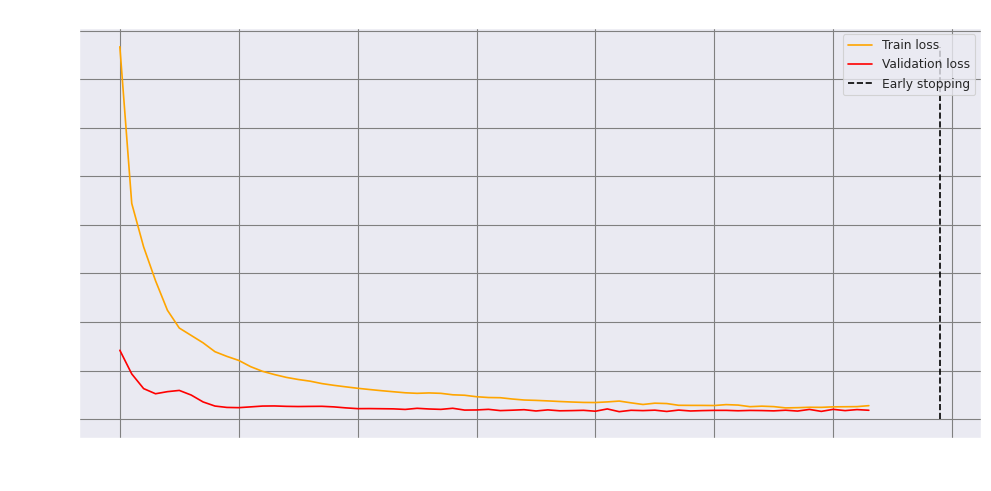

In [22]:
def create_rnn_model():
    start_time = time_.time()

    train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)

    input_size = train_data.shape[1]

    train_data = train_data.view(num_samples, -1, input_size)
    train_labels = tango_ori

    train_size = int(0.8*len(train_data))
    valid_size = len(train_data) - train_size

    valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
    train_data, train_labels = train_data[:train_size], train_labels[:train_size]

    train_data = train_data.view(train_size, -1, input_size)
    valid_data = valid_data.view(valid_size, -1, input_size)

    model = RNNOrientation(input_size, hidden_size, num_layers, output_size)
    model.to('cpu')
    criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=False, betas=betas)

    patience = 20
    min_valid_loss = np.inf
    patience_counter = 0

    train_losses = []
    valid_losses = []

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_data)
            valid_loss = criterion(valid_outputs, valid_labels)

        train_losses.append(loss.item())
        valid_losses.append(valid_loss.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

        if valid_loss < min_valid_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print('Early stopping')
            break

    print("Finished Training")

    elapsed_time = time_.time() - start_time
    print(f"Time taken to train the model: {elapsed_time} seconds")

    full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf, q_pred), dim=1)
    full_data = full_data.view(num_samples, -1, input_size)

    model.load_state_dict(torch.load('best_model.pt'))
    model.eval()
    with torch.no_grad():
        predictions = model(full_data.to('cpu'))

    return model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions

# Keep track of the best model
best_model = None
best_loss = np.inf
best_epoch = -1
best_train_losses = None
best_valid_losses = None
best_train_size = -1
best_predictions = None
best_elapsed_time = -1
rnn_loss = []
training_times = []

for i in range(1):
    model, loss, min_valid_loss, min_epoch, train_losses, valid_losses, train_size, elapsed_time, predictions = create_rnn_model()
    min_valid_loss = min_valid_loss.detach().numpy()

    rnn_loss.append(min_valid_loss)
    training_times.append(elapsed_time)

    if min_valid_loss < best_loss:
        best_model = model
        best_loss = min_valid_loss
        best_epoch = min_epoch
        best_train_losses = train_losses
        best_valid_losses = valid_losses
        best_train_size = train_size
        best_predictions = predictions
        best_elapsed_time = elapsed_time

print(f"Average loss: {np.mean(rnn_loss)} +/- {np.std(rnn_loss)}")
print(f"Average training time: {np.mean(training_times)} +/- {np.std(training_times)}")

# Plot the best model
network = 'RNN'
plot_quaternions(best_loss, dist_metric, agg_type, normal, best_predictions, tango_ori, time, best_train_size, network, filename='rnn_best_model')
plot_losses(best_train_losses, best_valid_losses, best_epoch, filename='rnn_losses')